# Flight segmentation template

a template for flight segmentation developers to work your way through the flight track piece by piece and define segments in time. An EC track and circles are exemplarily shown for 2024-08-13. A YAML file containing the segment time slices as well as optionally specified `kinds`, `name`, `irregularities` or `comments` is generated at the end.

If a flight includes overpasses of a station of the Meteor, you can import and use the function `plot_overpass` from `utils` which will also print the closest time and distance to the target.

In [1]:
import matplotlib
import yaml
import hvplot.xarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from navdata import get_navdata_HALO
from utils import get_sondes_l1, seg2yaml

In [2]:
flight_id = "HALO-20240813a"

## Get HALO position and attitude

In [3]:
ds = get_navdata_HALO(flight_id)

## Get dropsonde launch times

In [4]:
drops = get_sondes_l1(flight_id)
ds_drops = ds.sel(time=drops, method="nearest")

## Interactive plots

In [5]:
ds["alt"].hvplot()

:Curve   [time]   (WGS84 Datum/Elliptical Height)

In [6]:
ds["roll"].hvplot()

:Curve   [time]   (Attitude/Roll)

### Defining takeoff and landing
On Barbads, the airport runway plus bumps make HALO move between 7.8-8m above WGS84, on Sal between 88.2-88.4m above WGS84. We therefore define the flight time such that altitude must be above 9m on Barbados and 90m on Sal.

In [7]:
if ds.time[0].values > np.datetime64("2024-09-07T00:00:00"):
    airport_wgs84 = 9
else:
    airport_wgs84 = 90

In [8]:
takeoff = ds["time"].where(ds.alt > airport_wgs84, drop=True)[0].values
landing = ds["time"].where(ds.alt > airport_wgs84, drop=True)[-1].values
duration = (landing - takeoff).astype("timedelta64[m]").astype(int)
print("take-off: ", takeoff)
print("landing: ", landing)
print(f"flight duration: {int(duration / 60)}:{int(duration % 60)}")

take-off:  2024-08-13T14:15:39.000000000
landing:  2024-08-13T22:59:33.000000000
flight duration: 8:43


### Plot flight track and dropsonde locations

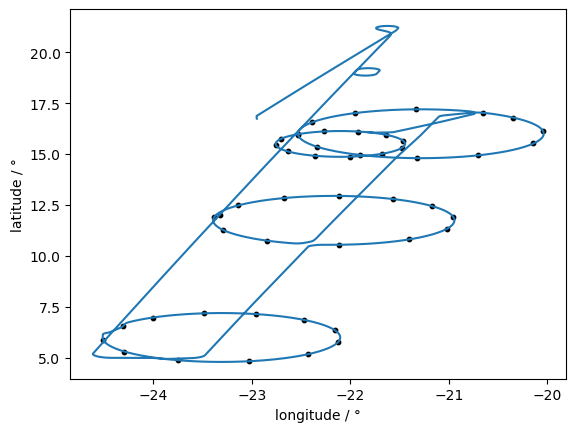

In [9]:
plt.plot(ds.lon.sel(time=slice(takeoff, landing)), ds.lat.sel(time=slice(takeoff, landing)))
plt.scatter(ds_drops.lon, ds_drops.lat, s=10, c="k")
plt.xlabel("longitude / °")
plt.ylabel("latitude / °");

## Segments

defined as a tuple of time slice (`start`, `end`) , segment `kind`, `name`, `irregularities`, and `comments`.

* in case of irregularities within a circle, 1 sec before the first and after the last sonde are chosen as start and end times
* use the irregularities to state any deviations, also with respective times
* use the comments field to state any further relevant information.

In [10]:
sl1 = (
    slice("2024-08-13T14:44:00", "2024-08-13T14:56:37"),
    ["straight_leg"],
)

ec = (
    slice("2024-08-13T15:25:02", "2024-08-13T17:13:36"),
    ["straight_leg", "ec_track"],
    "full EC track",
    [],
    ["several height level changes, for details, see subsegments"]
)

ec1 = (
    slice("2024-08-13T15:32:18", "2024-08-13T15:52:22"),
    ["straight_leg", "ec_track"],
    "EC track low leg",
)

ec2 = (
    slice("2024-08-13T15:57:05", "2024-08-13T17:01:53"),
    ["straight_leg", "ec_track"],
    "EC track mid leg",
)

ec3 = (
    slice("2024-08-13T17:05:35", "2024-08-13T17:13:36"),
    ["straight_leg", "ec_track"],
    "EC track high leg",
)

sl_south = (
    slice("2024-08-13T17:16:49", "2024-08-13T17:19:35"),
    ["straight_leg"],
    "straight leg south",
)

c1 = (
    slice("2024-08-13 17:21:20", "2024-08-13 18:23:20"),
    ["circle"],
    "circle south",
    ["deviation from circle track due to deep convection between 18:06:02 - 18:12:08"],
)

c2 = (
    slice("2024-08-13T19:15:37", "2024-08-13T20:13:48"),
    ["circle"],
    "circle mid",
)

c3 = (
    slice("2024-08-13 21:09:04", "2024-08-13 22:07:31"),
    ["circle"],
    "circle north",
    ["early circle start due to 1st sonde. Roll angle stable after 21:10:04"],
)

catr = (
    slice("2024-08-13 22:21:00", "2024-08-13 22:59:14"),
    ["circle", "atr_coordination"],
    "ATR circle",
    [],
    ["circle with ATR coordination and 72km radius"],
)

# add all segments that you want to save to a yaml file later to the below list
segments = [sl1, ec1, ec2, ec3, sl_south, c1, c2, c3, catr]

### Quick plot for working your way through the segments piece by piece
select the segment that you'd like to plot and optionally set the flag True for plotting the previous segment in your above specified list as well. The latter can be useful for the context if you have segments that are close or overlap in space, e.g. a leg crossing a circle.

Segment time: 2024-08-13 21:09:04 to 2024-08-13 22:07:31
Dropsonde launch times: ['2024-08-13T21:09:05.000000000' '2024-08-13T21:12:13.000000000'
 '2024-08-13T21:18:21.000000000' '2024-08-13T21:23:37.000000000'
 '2024-08-13T21:30:00.000000000' '2024-08-13T21:34:40.000000000'
 '2024-08-13T21:39:05.000000000' '2024-08-13T21:43:30.000000000'
 '2024-08-13T21:48:12.000000000' '2024-08-13T21:53:11.000000000'
 '2024-08-13T21:58:16.000000000' '2024-08-13T22:03:25.000000000']


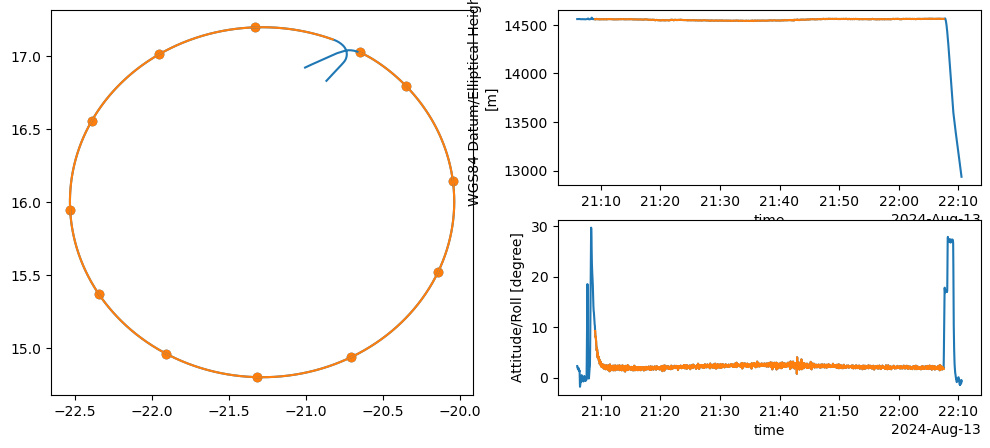

In [11]:
seg=c3
add_previous_seg = False

###########################

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[:, 0])

# extend the segment time period by 3min before and after to check outside dropsonde or roll angle conditions
seg_drops = slice(pd.Timestamp(seg[0].start) - pd.Timedelta("3min"), pd.Timestamp(seg[0].stop) + pd.Timedelta("3min"))
ax1.plot(ds.lon.sel(time=seg_drops), ds.lat.sel(time=seg_drops), "C0")

# plot the previous segment as well as the chosen one
if add_previous_seg:
    if segments.index(seg) > 0:
        seg_before = segments[segments.index(seg) - 1]
        ax1.plot(ds.lon.sel(time=seg_before[0]), ds.lat.sel(time=seg_before[0]), color="grey")
ax1.plot(ds.lon.sel(time=seg[0]), ds.lat.sel(time=seg[0]), color="C1")

# plot dropsonde markers for extended segment period as well as for the actually defined period
ax1.scatter(ds_drops.lon.sel(time=seg_drops), ds_drops.lat.sel(time=seg_drops), c="C0")
ax1.scatter(ds_drops.lon.sel(time=seg[0]), ds_drops.lat.sel(time=seg[0]), c="C1")

ax2 = fig.add_subplot(gs[0, 1])
ds["alt"].sel(time=seg_drops).plot(ax=ax2, color="C0")
ds["alt"].sel(time=seg[0]).plot(ax=ax2, color="C1")

ax3 = fig.add_subplot(gs[1, 1])
ds["roll"].sel(time=seg_drops).plot(ax=ax3, color="C0")
ds["roll"].sel(time=seg[0]).plot(ax=ax3, color="C1")

#Check dropsonde launch times compared to the segment start and end times
print(f"Segment time: {seg[0].start} to {seg[0].stop}")
print(f"Dropsonde launch times: {ds_drops.time.sel(time=seg_drops).values}")

## Save segments to YAML file

In [12]:
yaml.dump(seg2yaml(flight_id, ds, segments),
          open(f"../flight_segment_files/{flight_id}.yaml", "w"),
          sort_keys=False)